In [38]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
from collections import deque

from model import TicTacToeModel
from modelCNN import TicTacToeCNN


device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [39]:
class TicTacToeEnv:
    def __init__(self):  
        self.reset()

    def reset(self):
        self.board = np.zeros(9) 
        self.done = False
        return self.board

    def _check_win(self):
        win_indices = np.array([
            [0, 1, 2],
            [3, 4, 5],
            [6, 7, 8],
            [0, 3, 6],
            [1, 4, 7],
            [2, 5, 8],
            [0, 4, 8],
            [2, 4, 6],
        ])
        # victory
        if np.any(np.all(self.board[win_indices] == np.ones(3), axis=1)):
            return 1
        # defeat
        elif np.any(np.all(self.board[win_indices] == -np.ones(3), axis=1)):
            return -1
        # none
        else:
            return False
        
    def step(self, action):

        # Player move
        self.board[action] = 1
        win_check = self._check_win()
        if win_check == 1:  # Player wins
            reward = 1
            self.done = True
            return self.board, reward, self.done
        elif np.all(self.board != 0):  # Draw
            reward = 0.5
            self.done = True
            return self.board, reward, self.done

        # Opponent move
        self._opponent_step()
        win_check = self._check_win()
        if win_check == -1:  # Opponent wins
            reward = -1
            self.done = True
        elif np.all(self.board != 0):  # Draw after opponent's move
            reward = 0.5
            self.done = True
        else:
            reward = -0.01  # Game continues

        return self.board, reward, self.done
    
    def _opponent_step(self):
        valid_actions = np.where(self.board == 0)[0]
        action = np.random.choice(valid_actions)
        self.board[action] = -1
        

In [40]:
class DeepQAgent:
    def __init__(self, model_class, lr=1e-4, gamma=0.95, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.997):
        self.model = model_class().to(device)
        self.target_model = model_class().to(device)
        self.target_model.load_state_dict(self.model.state_dict())
        self.target_model.eval()
        self.action_size = 9
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.memory = deque(maxlen=10000) 
        self.loss_hist = []
        
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
    def act(self, state):
        valid_actions = np.where(state == 0)[0]  # Find valid actions
    
        # exploration: epsilon-greedy
        if np.random.rand() <= self.epsilon:
            return np.random.choice(valid_actions)
        # Get Q-values from the model
        state_tensor = torch.tensor(state, dtype=torch.float32).to(device).unsqueeze(0)  # Add batch dimension
        q_values = self.model(state_tensor).squeeze(0)  # Remove batch dimension
        # Mask invalid actions
        masked_q_values = torch.full_like(q_values, -float('inf')).to(device)
        masked_q_values[valid_actions] = q_values[valid_actions]
    
        return torch.argmax(masked_q_values).item()
    
    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        
        batch = random.sample(self.memory, batch_size)
        (states, actions, rewards, next_states, dones) = zip(*batch)
        states = torch.tensor(states, dtype=torch.float32).to(device)
        actions = torch.tensor(actions, dtype=torch.long).to(device)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        next_states = torch.tensor(next_states, dtype=torch.float32).to(device)
        dones = torch.tensor(dones, dtype=torch.float32).to(device)
        targets = self.model(states).detach().clone()
        next_q_values = self.target_model(next_states).detach()
        max_next_q_values = torch.max(next_q_values, 1)[0]
        # Update only the Q-values for the actions taken
        targets[range(batch_size), actions] = rewards + self.gamma * max_next_q_values * (1 - dones)
        self.optimizer.zero_grad()
        outputs = self.model(states)
        loss = F.smooth_l1_loss(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
        self.optimizer.step()
        self.loss_hist.append(loss.item())
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

In [41]:
episodes = int(1e+4)
env = TicTacToeEnv()
agent = DeepQAgent(TicTacToeCNN)

batch_size = 128
target_update_interval = 10

for episode in range(episodes):
    state = env.reset()
    total_reward = 0
    
    while True:
        # agent move
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        
        total_reward += reward
        if done:
            break
        
    agent.replay(batch_size)
    
    if episode % target_update_interval == 0:
        agent.update_target_model()
        
    print(f'Episode {episode}, Total reward: {total_reward:.2f}')

model = agent.model
torch.save(model, f"models\\model_conv_{episodes}.pth")

Episode 0, Total reward: 0.96
Episode 1, Total reward: 0.97
Episode 2, Total reward: -1.03
Episode 3, Total reward: -1.02
Episode 4, Total reward: 0.96
Episode 5, Total reward: 0.46
Episode 6, Total reward: 0.96
Episode 7, Total reward: -1.03
Episode 8, Total reward: -1.03
Episode 9, Total reward: -1.03
Episode 10, Total reward: 0.96
Episode 11, Total reward: 0.46
Episode 12, Total reward: 0.97
Episode 13, Total reward: 0.98
Episode 14, Total reward: 0.97
Episode 15, Total reward: 0.97
Episode 16, Total reward: 0.96
Episode 17, Total reward: -1.03
Episode 18, Total reward: 0.96
Episode 19, Total reward: -1.03
Episode 20, Total reward: 0.97
Episode 21, Total reward: 0.98
Episode 22, Total reward: -1.03
Episode 23, Total reward: 0.46
Episode 24, Total reward: 0.96
Episode 25, Total reward: 0.96
Episode 26, Total reward: 0.98
Episode 27, Total reward: 0.97
Episode 28, Total reward: 0.97
Episode 29, Total reward: 0.97
Episode 30, Total reward: 0.46
Episode 31, Total reward: -1.03
Episode 3

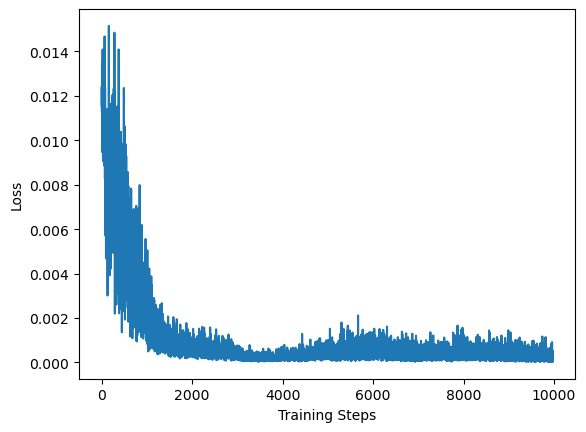

In [42]:
import matplotlib.pyplot as plt
plt.plot(agent.loss_hist)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.show()